<a href="https://colab.research.google.com/github/Eflalkryz/AkbankMachineLearningBootcamp/blob/main/HrDataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import warnings
warnings.simplefilter(action="ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [85]:
hr_data=pd.read_csv('sample_data/HR_capstone_dataset.csv')
hr_data.head(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.380,0.530,2,157,3,0,1,0,sales,low
1,0.800,0.860,5,262,6,0,1,0,sales,medium
2,0.110,0.880,7,272,4,0,1,0,sales,medium
3,0.720,0.870,5,223,5,0,1,0,sales,low
4,0.370,0.520,2,159,3,0,1,0,sales,low
5,0.410,0.500,2,153,3,0,1,0,sales,low
6,0.100,0.770,6,247,4,0,1,0,sales,low
7,0.920,0.850,5,259,5,0,1,0,sales,low
8,0.890,1.000,5,224,5,0,1,0,sales,low
9,0.420,0.530,2,142,3,0,1,0,sales,low


In [86]:
hr_data["salary"] = hr_data["salary"].apply(lambda x: 1 if x == "low" else (2 if x == "medium" else 3))
#It is a categorical data and we have to make it
hr_data["salary"].head(10)


0    1
1    2
2    2
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: salary, dtype: int64

In [87]:
def grab_col_names(dataframe, cat_th=5, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(hr_data)

print(cat_cols)
print(num_cols)
print(cat_but_car)



Observations: 14999
Variables: 10
cat_cols: 5
num_cols: 5
cat_but_car: 0
num_but_cat: 4
['Department', 'Work_accident', 'left', 'promotion_last_5years', 'salary']
['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company']
[]


In [88]:

def check_df(dataframe,num_cols, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe[num_cols].quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(hr_data, num_cols)

##################### Shape #####################
(14999, 10)
##################### Types #####################
satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
Department                object
salary                     int64
dtype: object
##################### Head #####################
   satisfaction_level  last_evaluation  number_project  average_montly_hours  time_spend_company  Work_accident  left  promotion_last_5years Department  salary
0               0.380            0.530               2                   157                   3              0     1                      0      sales       1
1               0.800            0.860               5                   262                   6              0     1                      0      sales       2
2              

             Department  Ratio
Department                    
sales              4140 27.602
technical          2720 18.135
support            2229 14.861
IT                 1227  8.181
product_mng         902  6.014
marketing           858  5.720
RandD               787  5.247
accounting          767  5.114
hr                  739  4.927
management          630  4.200
##########################################


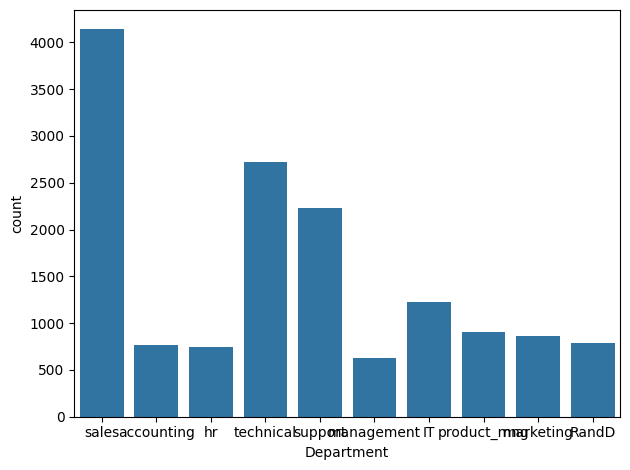

               Work_accident  Ratio
Work_accident                      
0                      12830 85.539
1                       2169 14.461
##########################################


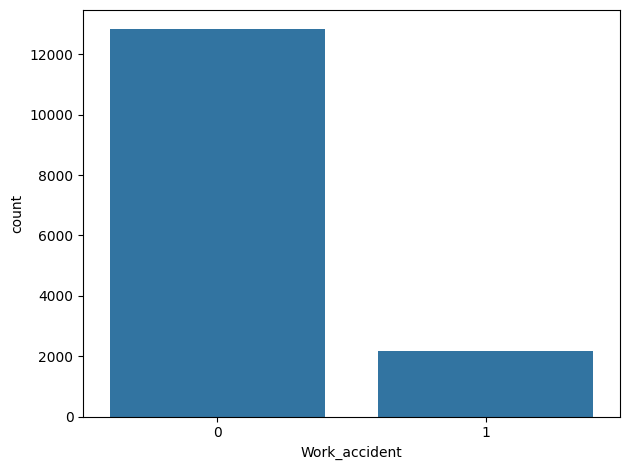

       left  Ratio
left              
0     11428 76.192
1      3571 23.808
##########################################


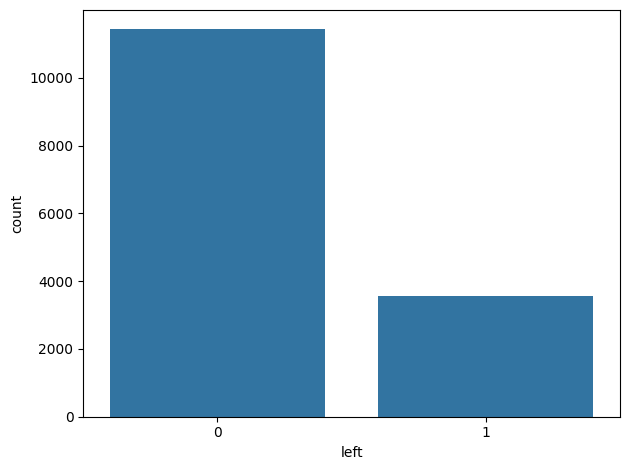

                       promotion_last_5years  Ratio
promotion_last_5years                              
0                                      14680 97.873
1                                        319  2.127
##########################################


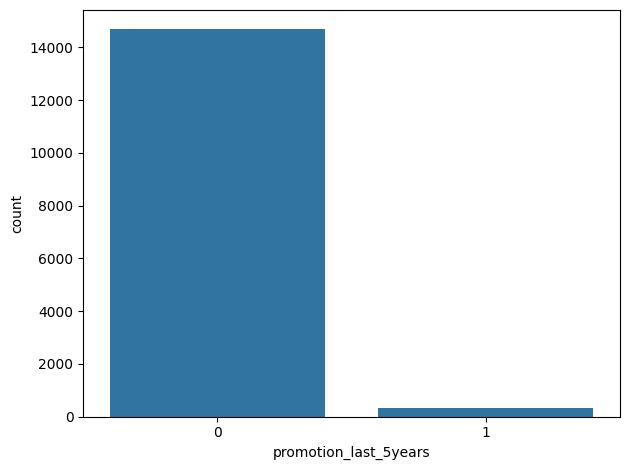

        salary  Ratio
salary               
1         7316 48.777
2         6446 42.976
3         1237  8.247
##########################################


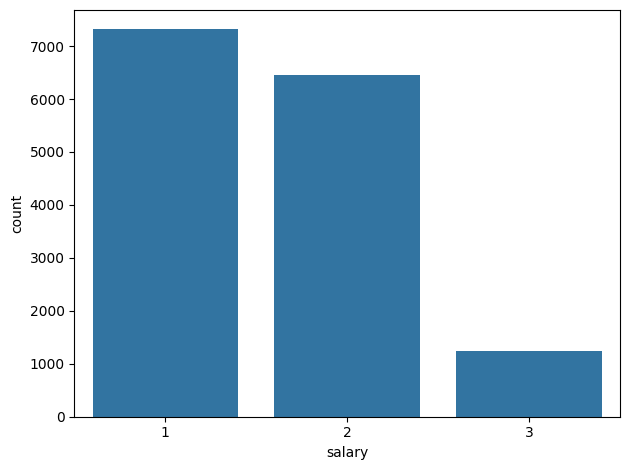

In [89]:

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.tight_layout()
        plt.show()

for col in cat_cols:
    cat_summary(hr_data, col,True)
    #we can see that the most crowded department is sales department. Most of people has low salary.


count   14999.000
mean        0.613
std         0.249
min         0.090
5%          0.110
10%         0.210
20%         0.400
30%         0.490
40%         0.570
50%         0.640
60%         0.720
70%         0.780
80%         0.850
90%         0.920
95%         0.960
99%         0.990
max         1.000
Name: satisfaction_level, dtype: float64


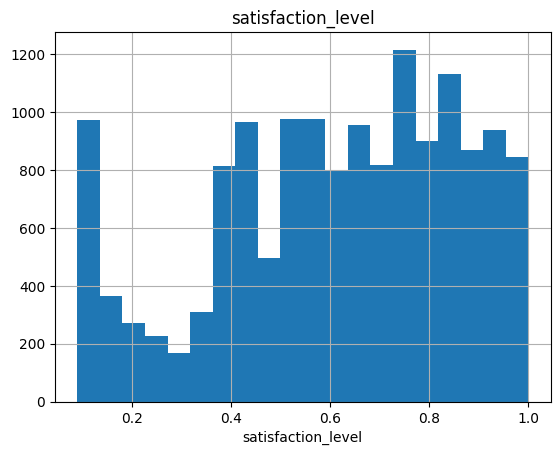

count   14999.000
mean        0.716
std         0.171
min         0.360
5%          0.460
10%         0.490
20%         0.540
30%         0.590
40%         0.650
50%         0.720
60%         0.780
70%         0.840
80%         0.890
90%         0.950
95%         0.980
99%         1.000
max         1.000
Name: last_evaluation, dtype: float64


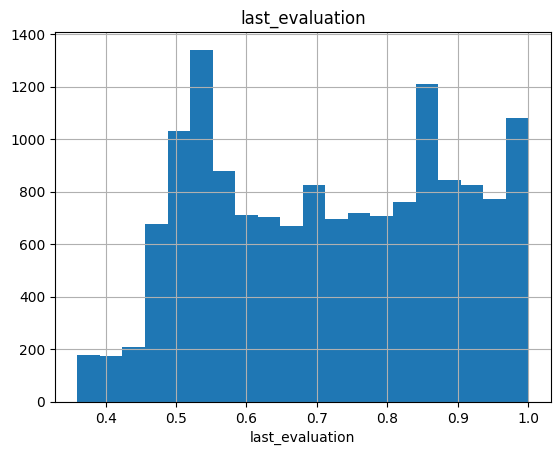

count   14999.000
mean        3.803
std         1.233
min         2.000
5%          2.000
10%         2.000
20%         3.000
30%         3.000
40%         3.000
50%         4.000
60%         4.000
70%         4.000
80%         5.000
90%         5.000
95%         6.000
99%         7.000
max         7.000
Name: number_project, dtype: float64


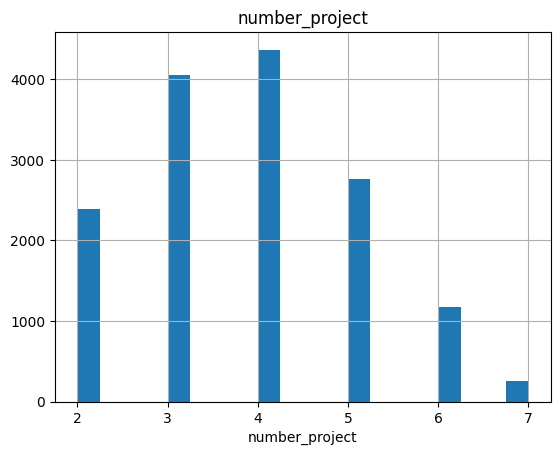

count   14999.000
mean      201.050
std        49.943
min        96.000
5%        130.000
10%       137.000
20%       150.000
30%       162.000
40%       181.000
50%       200.000
60%       220.000
70%       238.000
80%       253.000
90%       267.000
95%       275.000
99%       301.000
max       310.000
Name: average_montly_hours, dtype: float64


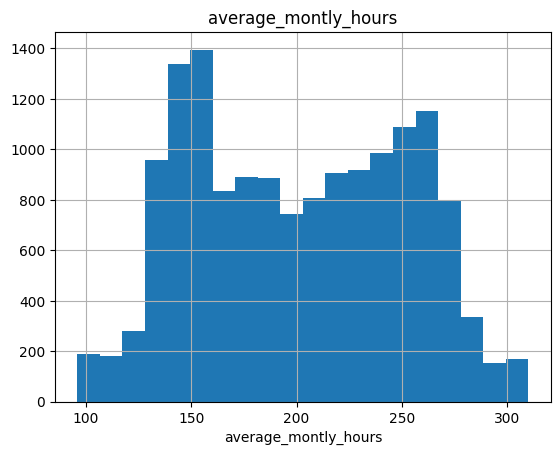

count   14999.000
mean        3.498
std         1.460
min         2.000
5%          2.000
10%         2.000
20%         2.000
30%         3.000
40%         3.000
50%         3.000
60%         3.000
70%         4.000
80%         4.000
90%         5.000
95%         6.000
99%        10.000
max        10.000
Name: time_spend_company, dtype: float64


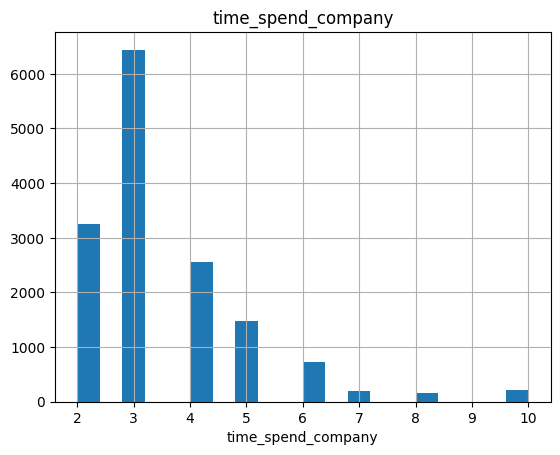

In [90]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

for col in num_cols:
    num_summary(hr_data, col, plot=True)

#Actually we can see from here there is not a big outlier but I will show that how can we make outlier analysis a few code later.


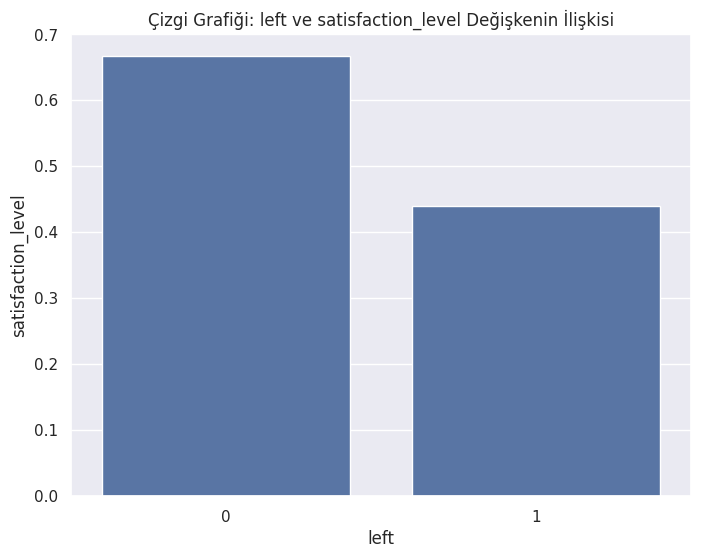

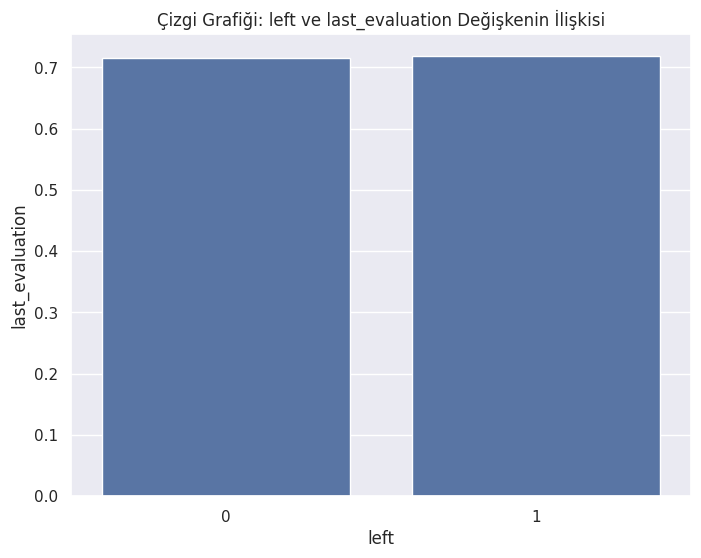

In [100]:
def plot_show(df, target, num_col):
  mean_values = df.groupby(target)[num_col].mean().reset_index()
  plt.figure(figsize=(8, 6))  # Grafiğin boyutunu ayarla
  sns.barplot(x=target, y=num_col, data=mean_values)

  # Grafik başlığı ekleme
  plt.title(f'Çizgi Grafiği: {target} ve {num_col} Değişkenin İlişkisi')

  # Eksen etiketlerini ekleme
  plt.xlabel(target)
  plt.ylabel(num_col)

  # Grafik gösterme
  plt.show()
plot_show(hr_data, "left", "satisfaction_level")
plot_show(hr_data, "left", "last_evaluation")

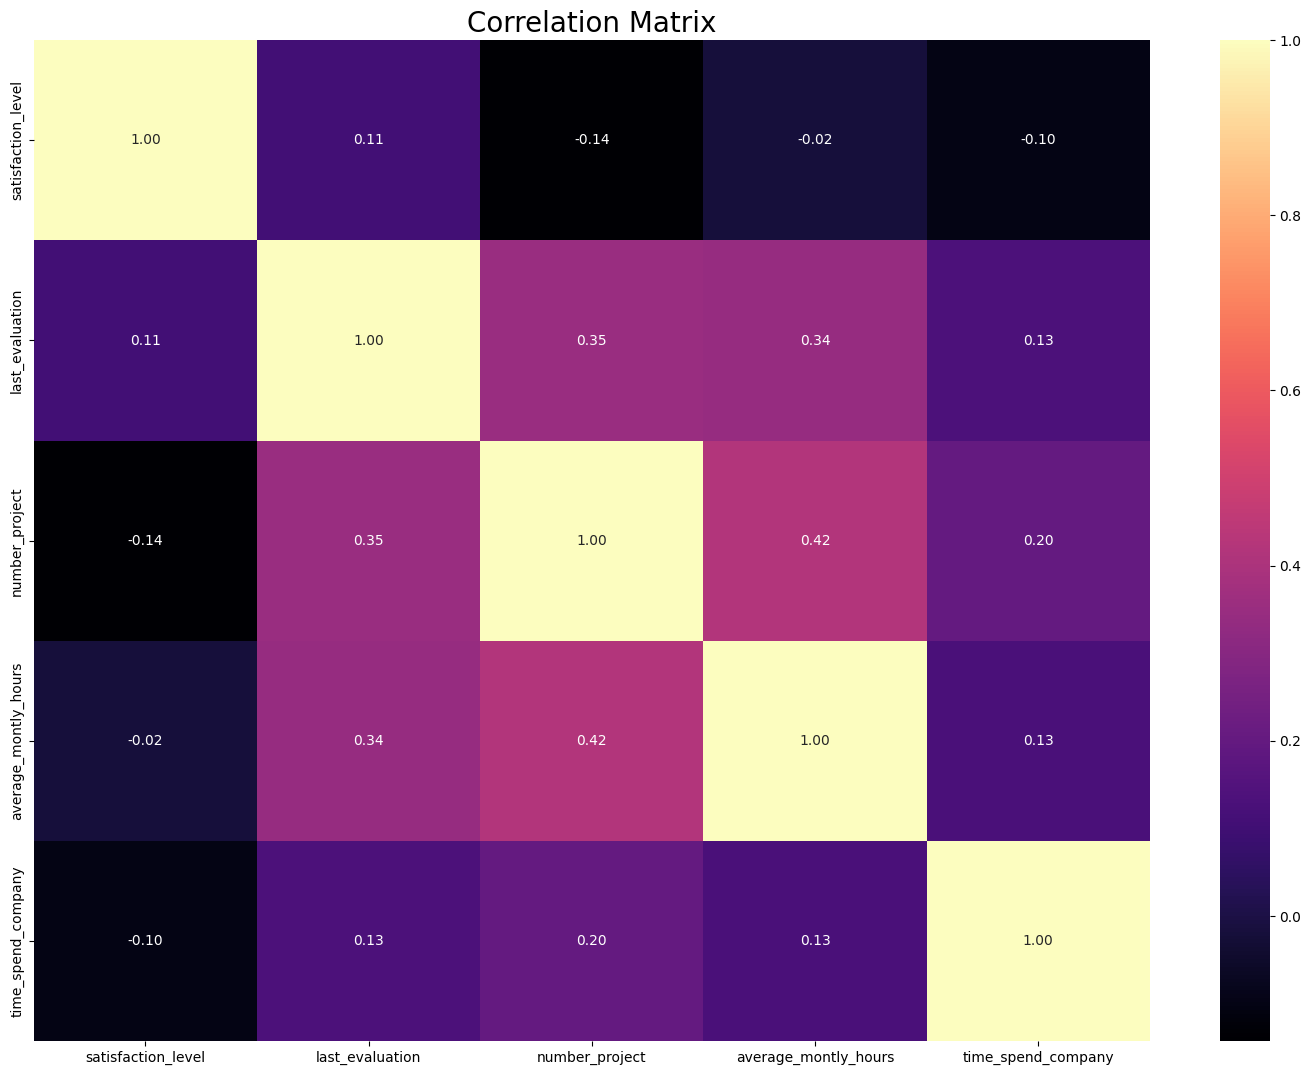

In [92]:
#Korelasyon Grafiğini çıkarmak için;

hr_data[num_cols].corr()

# Korelasyon Matrisi
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(hr_data[num_cols].corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()
#Genel olarak baktığımızda görüyoruz ki yüksek bir korelasyon yoktur.


In [93]:
hr_data.isnull().sum()
#We can see that there is not a null value but if it was.
#df["null_column"].fillna(df["null_column"].median(), inplace=True)


satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Department               0
salary                   0
dtype: int64

In [94]:
from sklearn.preprocessing import LabelEncoder
cat_cols = [col for col in cat_cols if col not in ["salary"]]
cat_cols
label_encoder = LabelEncoder()
# Her bir sütun için label encoding işlemini gerçekleştirme
for column in cat_cols:
    hr_data[column] = label_encoder.fit_transform(hr_data[column])


In [95]:
#I will find most convenient model making this.
y = hr_data["left"]
X = hr_data.drop(["left"], axis=1)


models = [('LR', LogisticRegression(random_state=12345)),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(random_state=12345)),
          ('RF', RandomForestClassifier(random_state=12345)),
          ('SVM', SVC(gamma='auto', random_state=12345)),
          ('XGB', XGBClassifier(random_state=12345)),
          ("LightGBM", LGBMClassifier(random_state=12345))]
for name, model in models:
    cv_results = cross_validate(model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc", "precision", "recall"])
    print(f"########## {name} ##########")
    print(f"Accuracy: {round(cv_results['test_accuracy'].mean(), 4)}")
    print(f"Auc: {round(cv_results['test_roc_auc'].mean(), 4)}")
    print(f"Recall: {round(cv_results['test_recall'].mean(), 4)}")
    print(f"Precision: {round(cv_results['test_precision'].mean(), 4)}")
    print(f"F1: {round(cv_results['test_f1'].mean(), 4)}")

    #Sınıflarım dengeli bir dağılıma sahip olduğu için accuracy e bakarak random forest classifier seçeceğim.



########## LR ##########
Accuracy: 0.7848
Auc: 0.8115
Recall: 0.3464
Precision: 0.5929
F1: 0.4331
########## KNN ##########
Accuracy: 0.9334
Auc: 0.973
Recall: 0.9174
Precision: 0.824
F1: 0.868
########## CART ##########
Accuracy: 0.9823
Auc: 0.9789
Recall: 0.9725
Precision: 0.954
F1: 0.9629
########## RF ##########
Accuracy: 0.9929
Auc: 0.9939
Recall: 0.9754
Precision: 0.9948
F1: 0.9847
########## SVM ##########
Accuracy: 0.9522
Auc: 0.9725
Recall: 0.9123
Precision: 0.8903
F1: 0.901
########## XGB ##########
Accuracy: 0.9903
Auc: 0.9937
Recall: 0.9714
Precision: 0.9877
F1: 0.9793
[LightGBM] [Info] Number of positive: 3213, number of negative: 10286
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 409
[LightGBM] [Info] Number of data points in the train set: 13499, number of used fea

In [97]:
rf_model = RandomForestClassifier(random_state=17)

rf_params = {"max_depth": [5, 8, None],
             "max_features": [3, 5, "auto"],
             "min_samples_split": [2, 5, 8],
             "n_estimators": [100, 200]}

rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

rf_best_grid.best_params_

rf_best_grid.best_score_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


0.9919996443258864

In [98]:
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X, y)


cv_results = cross_validate(rf_final, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()
cv_results['test_f1'].mean()
cv_results['test_roc_auc'].mean()


0.9940636212243298

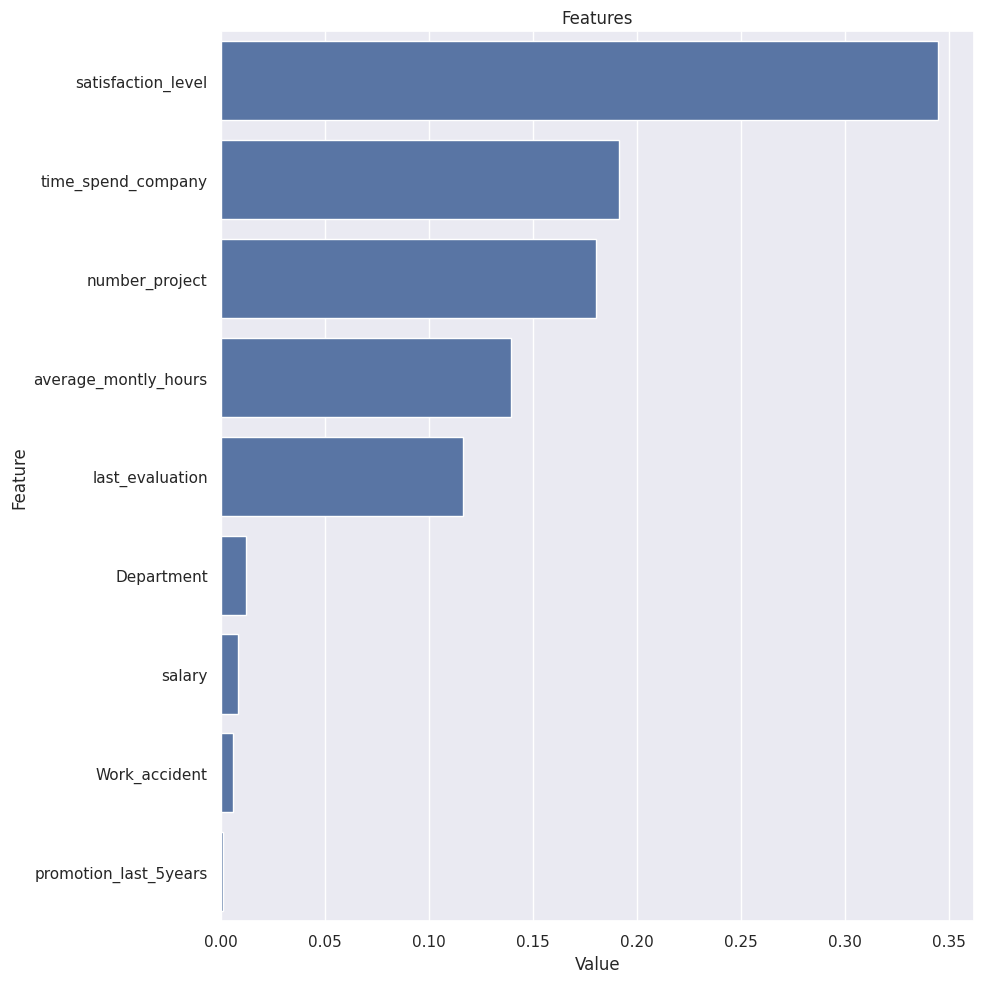

In [99]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_final, X)
#Mantıklı düşünürsek de zaten bir çalışan işinden memnunsa işten ayrılmaz tahmin modelimizin doğru çalıştığını görebiliyoruz.